# Source contributions

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy
import seaborn as sns; sns.set()
import pandas as pd

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model result set:
results_folder1 = '/data/brogalla/run_storage/Mn-reference-202110/'

colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

###### Load files:

In [4]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)

In [5]:
# Component contribution calculations:
CB_totals_ref,   CB_totals_spm,   CB_totals_bio   = pickle.load(open('calculations/Canada-Basin-totals-202110.pickle','rb')) 
CAA_totals_ref,  CAA_totals_spm,  CAA_totals_bio  = pickle.load(open('calculations/CAA-totals-202110.pickle' ,'rb')) 
wCAA_totals_ref, wCAA_totals_spm, wCAA_totals_bio = pickle.load(open('calculations/wCAA-totals-202110.pickle','rb'))  
eCAA_totals_ref, eCAA_totals_spm, eCAA_totals_bio = pickle.load(open('calculations/eCAA-totals-202110.pickle','rb')) 
totals_ref     , totals_spm     , totals_bio      = pickle.load(open('calculations/full-domain-totals-202110.pickle','rb')) 

In [6]:
# Component contribution calculations:
CB_averages_ref,   CB_averages_spm,   CB_averages_bio   = pickle.load(open('calculations/Canada-Basin-averages-202110.pickle','rb')) 
CAA_averages_ref,  CAA_averages_spm,  CAA_averages_bio  = pickle.load(open('calculations/CAA-averages-202110.pickle' ,'rb')) 
wCAA_averages_ref, wCAA_averages_spm, wCAA_averages_bio = pickle.load(open('calculations/wCAA-averages-202110.pickle','rb'))  
eCAA_averages_ref, eCAA_averages_spm, eCAA_averages_bio = pickle.load(open('calculations/eCAA-averages-202110.pickle','rb')) 
averages_ref     , averages_spm     , averages_bio      = pickle.load(open('calculations/full-domain-averages-202110.pickle','rb')) 

In [7]:
def reshape_arrays(array_in, riv=False, exp1=None, exp3=None):
    fixed      = np.zeros((len(years),8))
    
    for i in range(0,8):
        if i==0: # Sum the particulate and dissolved river contributions
            fixed[:,i] = array_in[:,i] + array_in[:,i+1]
        else:
            fixed[:,i] = array_in[:,i+1]
    
    return fixed

In [8]:
totals_ref_fixed      = reshape_arrays(totals_ref)
CB_totals_ref_fixed   = reshape_arrays(CB_totals_ref)
CAA_totals_ref_fixed  = reshape_arrays(CAA_totals_ref)
wCAA_totals_ref_fixed = reshape_arrays(wCAA_totals_ref)
eCAA_totals_ref_fixed = reshape_arrays(eCAA_totals_ref)

In [9]:
# Find indices to separate out Canada Basin:
x_ind = np.arange(1621, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []
for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2179,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

# Separate Canada Basin:
mask_ini_CB  = np.zeros((isize,jsize))
for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    
mask_ini_CB[150:-1 ,-8:-1] = 1

mask_CB_yr    = np.tile(mask_ini_CB  , (12,1,1))
mask_CB_depth = np.tile(mask_CB_yr  , (50,1,1,1))
mask_CB_depth = mask_CB_depth.reshape(12,50,700,640)

##### Functions:

In [10]:
def read_yearly_mn(years, results_folder=results_folder1):
    
    yearly_mn = []
    for year in years:
        Mn_model1  = nc.Dataset(f'{results_folder}ANHA12_ref-{year}_20211012/ANHA12_EXH006_{year}_monthly.nc')
        Mn_dis1    = np.array(Mn_model1.variables['dissolmn'])[:,0,:,:,:] # mol / L
        
        # Only interested in Mn content of the Canada Basin:
        Mn_CB      = np.ma.masked_where(mask_CB_depth==0, Mn_dis1) 
        
        # Polar mixed layer:
        Mn_content = Mn_CB[:,0:17,:,:]*volume_masked[0:17,:,:]*1e3 # mol / L --> monthly mole content per grid cell
        Mn_yearly  = np.ma.sum(Mn_content, axis=(0,1,2,3)) # Sum over months and over all grid cells and depths
        
        yearly_mn.append(Mn_yearly) # moles
        
    return np.array(yearly_mn)

### Figures

Year-to-year variation in contribution

In [11]:
# regions are defined in: 
# https://nsidc.org/sites/nsidc.org/files/files/data/noaa/g02135/Sea-Ice-Analysis-Spreadsheets-Overview.pdf
# This file is for the Beaufort Sea region, i.e. Canada Basin
sea_ice_CB          = '/ocean/brogalla/GEOTRACES/data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.csv'
observ_data_CB      = np.array(pd.read_csv(sea_ice_CB))
observ_years_CB     = observ_data_CB[:,0].astype('float')
monthly_ice_area_CB = observ_data_CB[:,1:].astype('float') # in km2

ice_areas_CB        = monthly_ice_area_CB.flatten()
# Calculate month-to-month change in sea ice area:
ice_areas_diff_CB   = [ice_areas_CB[i+1] - ice_areas_CB[i] for i in range(0,len(ice_areas_CB)-1)]
ice_areas_diff_CB   = np.append(np.nan, ice_areas_diff_CB)

monthly_area_change_CB = ice_areas_diff_CB.reshape([41,12]) # dimensions: years, months
# Only keep sea negative changes in ice area, i.e. melt:
monthly_area_melt_CB   = np.copy(monthly_area_change_CB)
monthly_area_melt_CB[monthly_area_change_CB > 0] = np.nan

# Calculate the sum of all the melt in a year:
yearly_melt_CB = np.abs(np.nansum(monthly_area_melt_CB, axis=1))

#### Canada Basin Mn content over time:

In [12]:
CB_mn_timeseries = read_yearly_mn(years)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an err

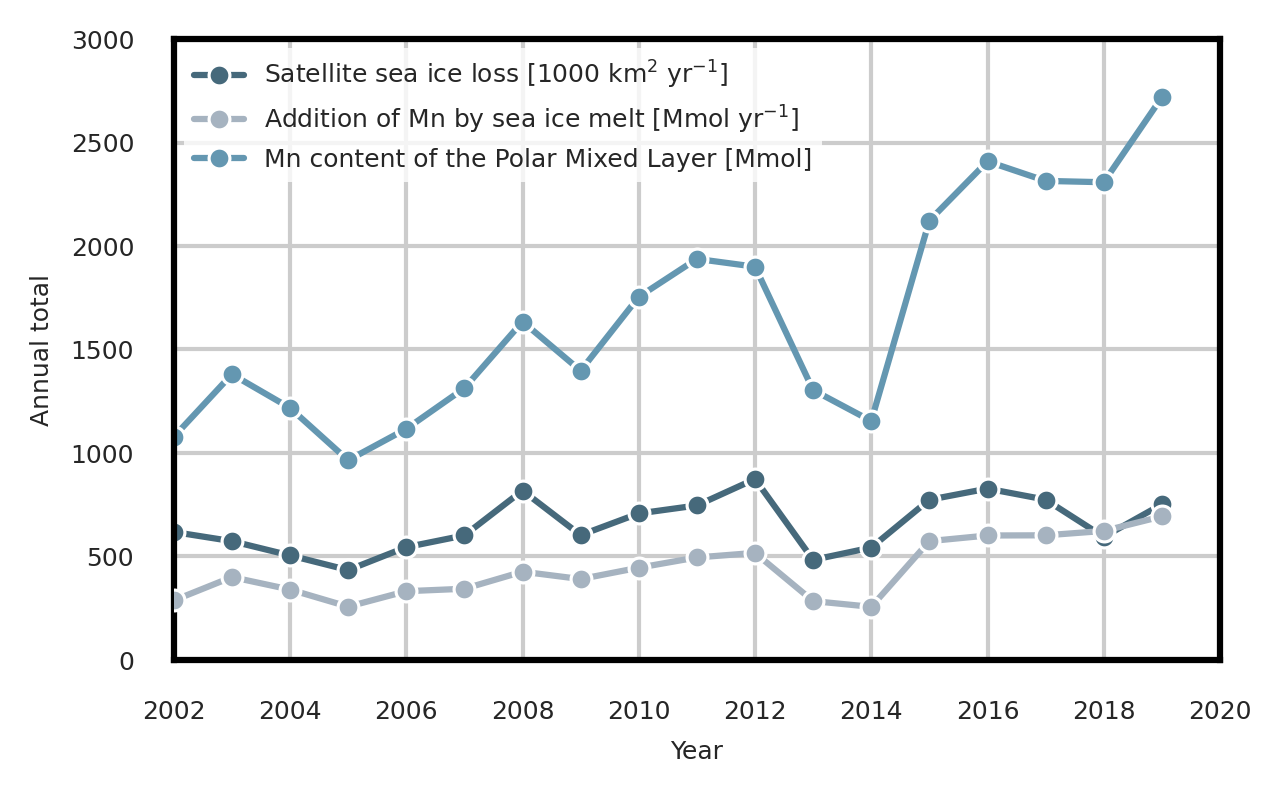

In [31]:
fig = plt.figure(figsize=(4.5, 2.74), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(observ_years_CB[0:-1], yearly_melt_CB[0:-1]*1e-3, linewidth=1.5, marker='o', markersize=5, color='#46697b',\
                       label=r'Satellite sea ice loss [1000 km$^{2}$ yr$^{-1}$]', zorder=1)
    sns.lineplot(years, CB_totals_ref_fixed[:,2]*1e-6, linewidth=1.5, color='#a6b3c0', marker="o", \
                 markersize=5, label=r'Addition of Mn by sea ice melt [Mmol yr$^{-1}$]', zorder=3)
    sns.lineplot(years, CB_mn_timeseries*1e-6, linewidth=1.5, marker='o', markersize=5, color='#6497b1', \
                 label=r'Mn content of the Polar Mixed Layer [Mmol]', zorder=2)
    
    ax.set_xlabel('Year', fontsize=6)
    ax.set_ylabel('Annual total',fontsize=6)
    ax.set(xlim=(2002, 2020), ylim=(0, 3000))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.01, 0.77), frameon=True, framealpha=0.8, fontsize=6)
    leg.get_frame().set_linewidth(0.0)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/D1-interannual-time-series.png', \
                    bbox_inches='tight',dpi=300)
fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/D1-interannual-time-series.svg', \
                    bbox_inches='tight',dpi=300,format='svg')

In [17]:
# Correlation between: Mn content of the Canada Basin polar mixed layer & model sea ice melt
slope, intercept, r_value1, p_value, std_err = scipy.stats.linregress(CB_mn_timeseries, CB_totals_ref_fixed[:,2])
print('R-squared value: %f' % r_value1**2)

# Correlation between: Mn model sea ice melt & observed satellite sea ice loss:
slope, intercept, r_value2, p_value, std_err = scipy.stats.linregress(CB_totals_ref_fixed[:,2], yearly_melt_CB[22:-1])
print('R-squared value: %f' % r_value2**2)

R-squared value: 0.963362
R-squared value: 0.535989
